<a href="https://colab.research.google.com/github/MrMazagngy/Quora-Question-Pair-Similarity/blob/main/BERT_%2B_CNN_Quora_Quesions_Pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download quora-question-pairs
!unzip \*.zip  && rm *.zip

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import transformers
import torch 
from torch import nn
import numpy as np
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns 
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download("popular")


In [7]:
#Vaiables 
RANDOM_SEED = 2
max_length = 128
BATCH_SIZE = 32
EPOCHS = 10

In [8]:
#Define the Bert Tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
#We will only work with the train set due to limited computational power
df = pd.read_csv('train.csv')
len(df)
df = df[-300:]

In [10]:
def preprocess(series):
  #remove characters other than alphabets & numerics
  words = re.sub("[^A-Za-z0-9]"," ",str(series)).lower().split()

  #lemmatize words
  lemm = WordNetLemmatizer()
  stpwords = stopwords.words('english')
  lemmitized = [lemm.lemmatize(word) for word in words if word not in stpwords]
  sent = ' '.join(lemmitized)
  return sent

In [ ]:
#Apply preprocessing

df['question1'] =df['question1'].apply(preprocess)
df['question2'] =df['question2'].apply(preprocess)

In [10]:
class Bert_QA (Dataset):
    def __init__(self,q1,q2,label,max_length) :
      self.q1  = q1
      self.q2  = q2
      self.label  = label
      self.max_length = max_length

    def __len__(self):
      return len(self.q1)

    def __getitem__ (self,item):
      q1 = str(self.q1[item])
      q2 = str(self.q2[item])

      input = tokenizer.encode_plus (q1 ,q2  ,
                                     add_special_tokens = True,
                                     max_length = self.max_length,      
                                     return_token_type_ids=False,
                                     padding='max_length',
                                     return_attention_mask=True,
                                     truncation = True,
                                     return_tensors='pt',)
      ids = input['input_ids']
      mask = input['attention_mask']

      return {
          'input_ids' : torch.tensor(ids,dtype=torch.long),
          'attention_mask' : torch.tensor(mask,dtype=torch.long),
          'target' : torch.tensor(int(self.label[item]),dtype=torch.float)

      }

In [11]:
#Dataset splitting into train , validation , test
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.25, random_state=RANDOM_SEED)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


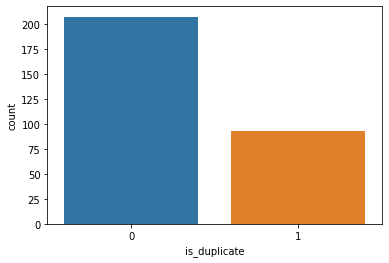

In [14]:
#Check for Imbablanced labels
sns.countplot(df.is_duplicate)

In [12]:
def create_data_loader(df, max_len, batch_size):
  ds = Bert_QA(
    q1=df.question1.to_numpy(),
    q2=df.question2.to_numpy(),
    label=df.is_duplicate.to_numpy(),
    max_length=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True
  )

In [13]:
train_data_loader = create_data_loader(df_train, max_length, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, max_length, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, max_length, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
#Model Archticture
class Bert_model (nn.Module):
  def __init__(self) :
    super(Bert_model,self).__init__()
    self.bert =  BertModel.from_pretrained('bert-base-uncased', return_dict=False)
    self.drop_layer = nn.Dropout(.25)
    self.output = nn.Linear(self.bert.config.hidden_size-2,1)
    self.cnn = nn.Conv1d(max_length,1,3)

  def forward(self,input_ids,attention_mask):
    o1,o2 = self.bert (input_ids =input_ids , attention_mask = attention_mask )
    o1 = self.cnn(o1)
    o1 = torch.flatten(o1, start_dim=1)
    o1 = self.drop_layer(o1)
    out = torch.sigmoid(self.output(o1))
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Bert_model()
model = model.to(device)
print(model)

In [16]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, weight_decay=1e-5) #Optimizer with Regularization

loss_fn = nn.BCELoss() #Loss Function

In [17]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["target"].to(device)

    input_ids = input_ids.view(BATCH_SIZE,-1)
    attention_mask = attention_mask.view(BATCH_SIZE,-1)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    targets = targets.unsqueeze(-1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(np.round(outputs.detach()) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_epoch(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["target"].to(device)
      input_ids = input_ids.view(BATCH_SIZE,-1)
      attention_mask = attention_mask.view(BATCH_SIZE,-1)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      targets = targets.unsqueeze(-1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(np.round(outputs.detach()) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_epoch(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_loss'], label='train Loss')
plt.plot(history['val_loss'], label='validation Loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()